This notebook contains a general overview of some clustering methods applied to the text dataset.  It is not particularly in depth, and a number of different methods are tried (including document embeddings both from gensim and from spacy's built-in vectorizations based on averaging word vectors).  It is not well documented, and is really just a brief exploration of methods.

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

%matplotlib inline

## Clustering Subreddits

**Read in subs:**

In [2]:
cats = ['art', 'gaming', 'music', 'politics_news', 'reading', 'science', 'sports', 'tech']
stem = 'lemma'

In [3]:
documents = []

for cat in cats:
    os.chdir(fr'..\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'..\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        documents.append((' '.join([comment['comment'] for comment in comments]), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [4]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

**Plot to visualize:**

In [5]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X_plot = tfidf_vectorizer.fit_transform(documents[:, 0])
svd_plot = TruncatedSVD(n_components=2)
X_plot = svd_plot.fit_transform(X_plot)

In [7]:
def get_label(i, colors, documents):
    if colors[documents[i][1]][1] == 0:
        colors[documents[i][1]][1] += 1
        return documents[i][1]
    else:
        return ""

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

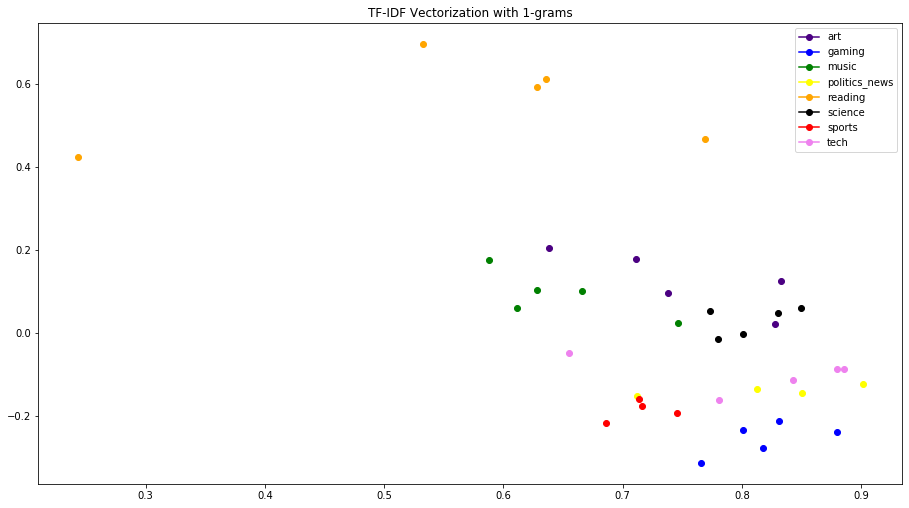

In [9]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

**K-Means**

In [11]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [12]:
km = MiniBatchKMeans(n_clusters=len(cats), init='k-means++', n_init=3, init_size=1000, batch_size=1000)
km.fit(X)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

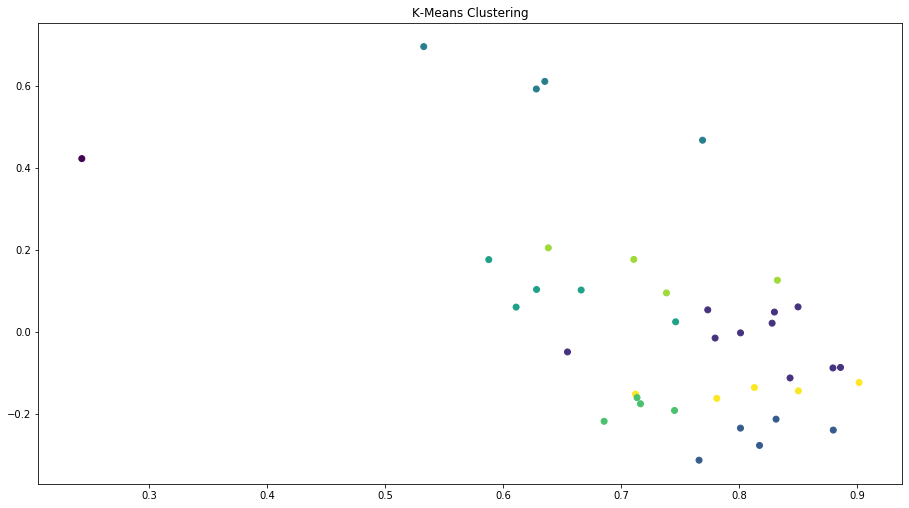

In [24]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

In [25]:
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.849
Completeness: 0.899
V-measure: 0.873


This is a fantastic start!

In [26]:
print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.5076415088512567


Silhouette score is decent but not fantastic.

## Clustering Posts

I think this is the more interesting part.

**Read in posts:**

In [3]:
documents = []

for cat in cats:
    os.chdir(fr'..\Data\{cat}\Processed\{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'..\Data\{cat}\Processed\{stem}\{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [4]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

**Plot for visualization**

In [32]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X_plot = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD()

X_plot = svd.fit_transform(X_plot)

Text(0.5, 1.0, 'TF-IDF Vectorization with 1-grams')

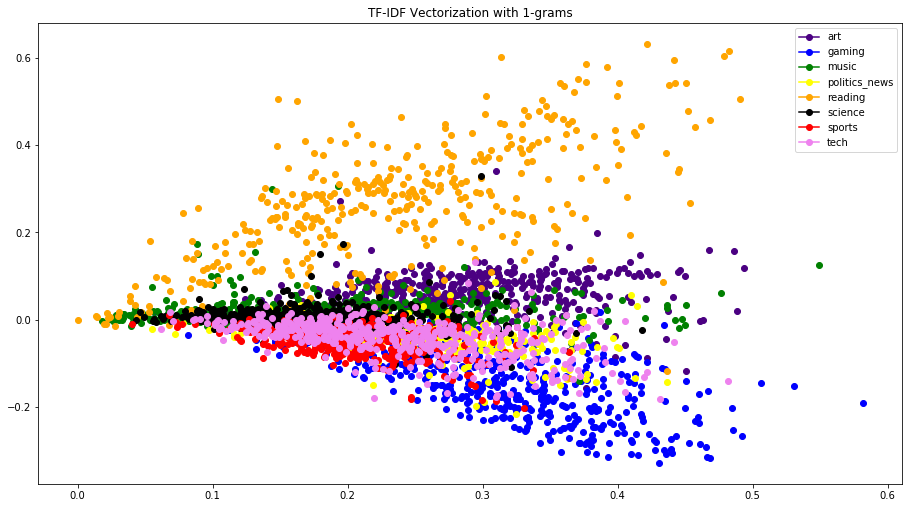

In [33]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()
ax.set_title('TF-IDF Vectorization with 1-grams')

**K-Means**

In [31]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [34]:
km = MiniBatchKMeans(n_clusters=len(cats), init='k-means++', n_init=3, init_size=1000, batch_size=1000)
km.fit(X)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

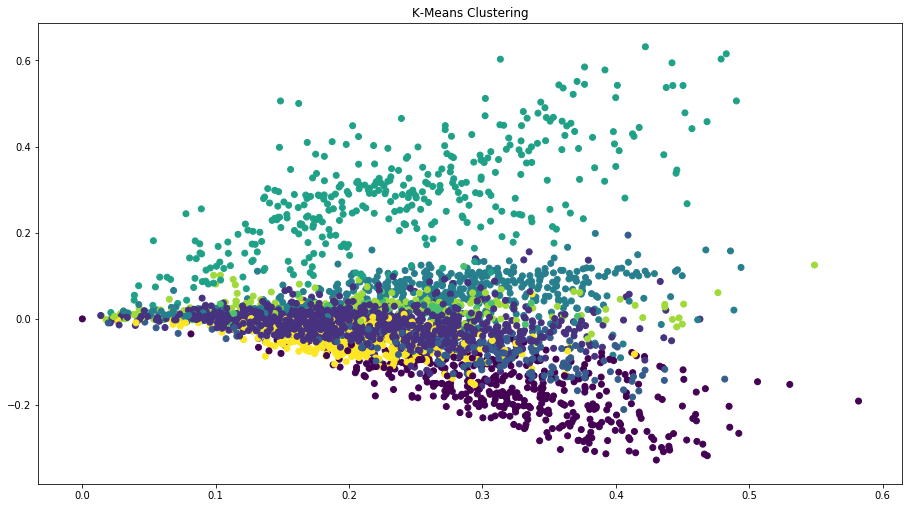

In [35]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

In [36]:
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.595
Completeness: 0.646
V-measure: 0.619


In [37]:
print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.41917222864235687


This is a bit rough!  However, I don't think it's possible to get perfect external measures for this clustering.  Let's play around a bit with parameters.  For one, let's reduce our tf-idf vectors to be 2-dimensional and keep the same number of clusters:

In [38]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [39]:
km = MiniBatchKMeans(n_clusters=len(cats), init='k-means++', n_init=3, init_size=1000, batch_size=1000)
km.fit(X)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

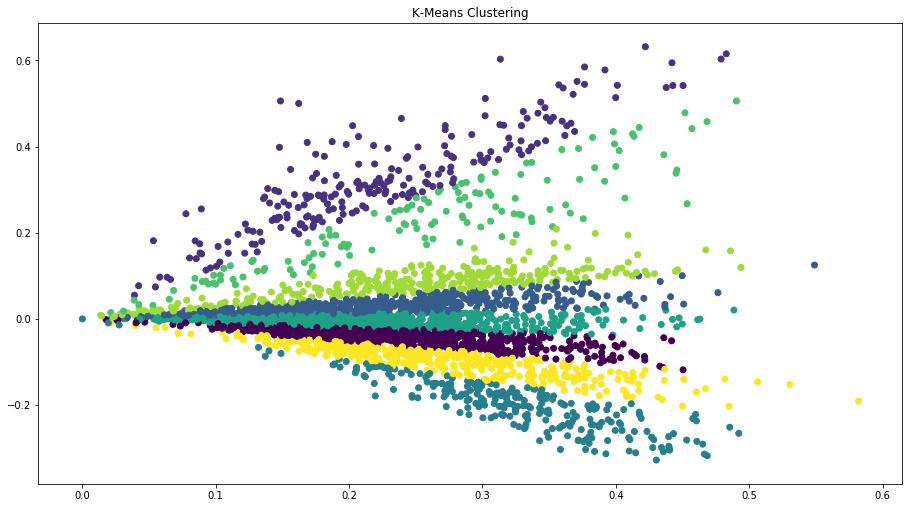

In [40]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

This is incredibly neat, but let's see how it performs:

In [41]:
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.363
Completeness: 0.391
V-measure: 0.376


Terrible external measures, but I think we should move beyond external measures.

In [42]:
print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.5342365916334324


So, silhouette score has improved a bit over the old model.  Let's take a look at total inertia:

In [43]:
print(f'Inertia: {km.inertia_}')

Inertia: 11.605101816887542


This isn't terrible, but can we do better?  Let's keep the number of components at 2 and look for a better k using the elbow method:

In [44]:
sse = []
list_k = list(range(2, 30))
for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++')
    km.fit(X)
    sse.append(km.inertia_)

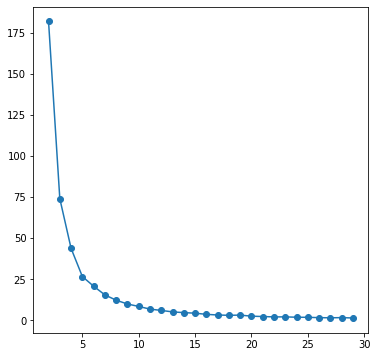

In [45]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, marker='o')

Let's choose k=15:

In [46]:
km = MiniBatchKMeans(n_clusters=15, init='k-means++')
km.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=15, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

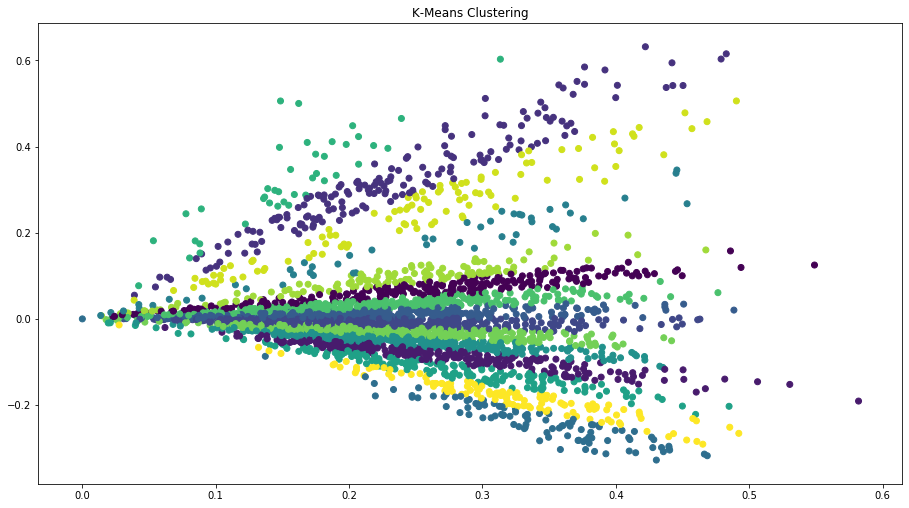

In [47]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

In [49]:
print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.5162430749173887


In [50]:
print(f'Inertia: {km.inertia_}')

Inertia: 3.9431990106479313


## Using Word Embeddings

In [5]:
import spacy

In [6]:
nlp = spacy.load("en_core_web_lg")

In [30]:
doc_vectors = []
for document in documents:
    doc = nlp(str(document[0]))
    doc_vectors.append(doc.vector)

In [7]:
import pickle

In [35]:
pickle.dump(doc_vectors, open('document_vectors.pickle', 'wb'))

In [8]:
import os

In [20]:
doc_vectors = pickle.load(open('document_vectors.pickle', 'rb'))

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(doc_vectors)

transformed = pca.transform(doc_vectors)

In [32]:
doc_vectors = np.array(doc_vectors)

In [33]:
def get_label(i, colors, documents):
    if colors[documents[i][1]][1] == 0:
        colors[documents[i][1]][1] += 1
        return documents[i][1]
    else:
        return ""

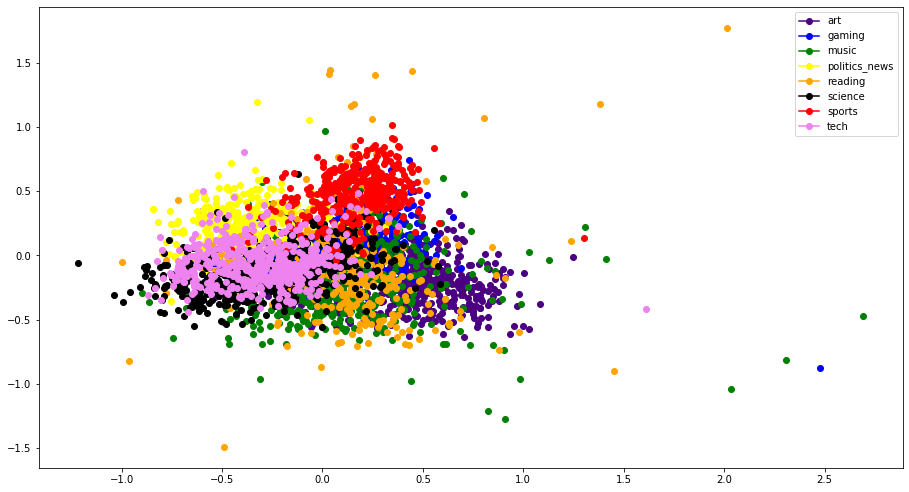

In [34]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(transformed):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()

In [39]:
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(doc_scaled)

transformed = pca.transform(doc_scaled)

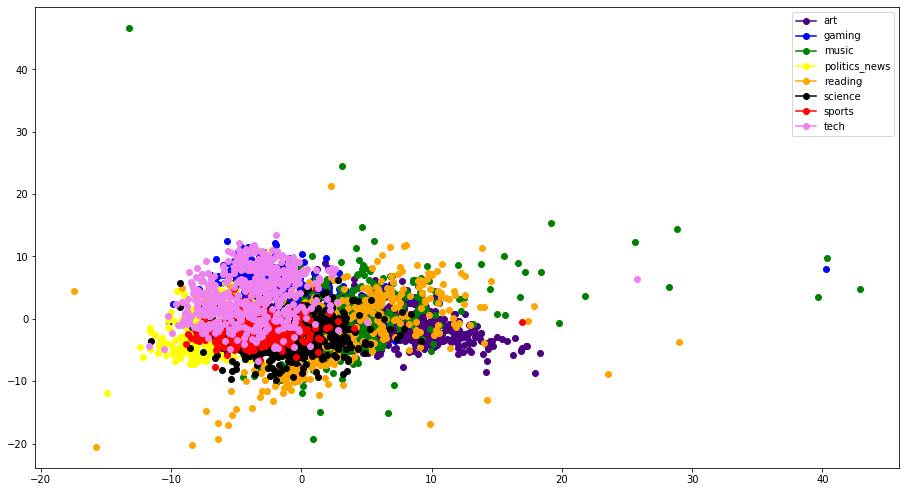

In [40]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(transformed):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()

**K-Means with Embeddings**

In [47]:
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)

In [48]:
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(svd_solver='randomized')
pca.fit(doc_scaled)

transformed = pca.transform(doc_scaled)

In [49]:
km = MiniBatchKMeans(n_clusters=len(cats), init='k-means++', n_init=3, init_size=1000, batch_size=1000)
km.fit(transformed)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

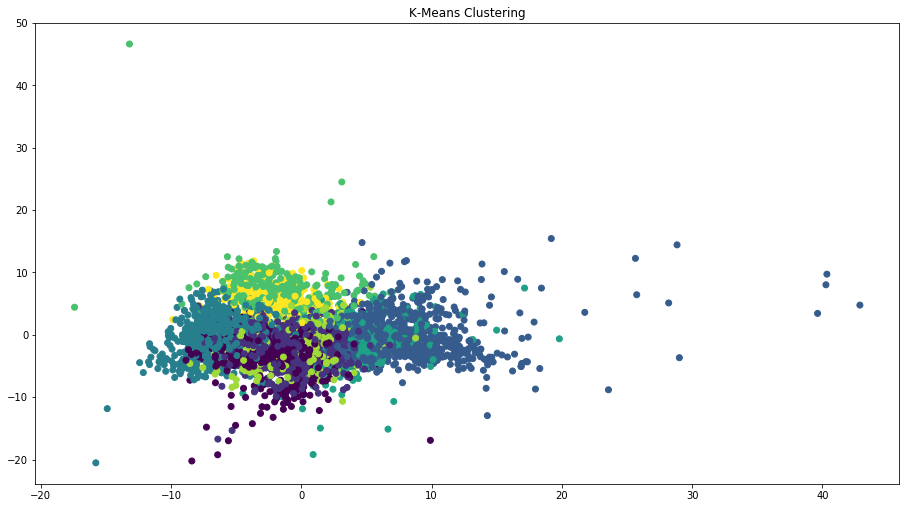

In [50]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

In [51]:
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.507
Completeness: 0.521
V-measure: 0.514


In [52]:
print(f'Silhouette score: {metrics.silhouette_score(transformed, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.06610824912786484


## Using Gensim

In [62]:
import gensim

In [77]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [271]:
docs = list(documents[:, 0])

In [272]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [273]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)

In [274]:
model.build_vocab(tagged_data)

In [275]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [276]:
doc_vectors = []
for i in range(0, len(tagged_data)):
    doc_vectors.append(model[str(i)])

In [277]:
doc_vectors = np.array(doc_vectors)

In [278]:
pca = PCA(n_components=2, svd_solver='randomized')
pca.fit(doc_vectors)

X_plot = pca.transform(doc_vectors)

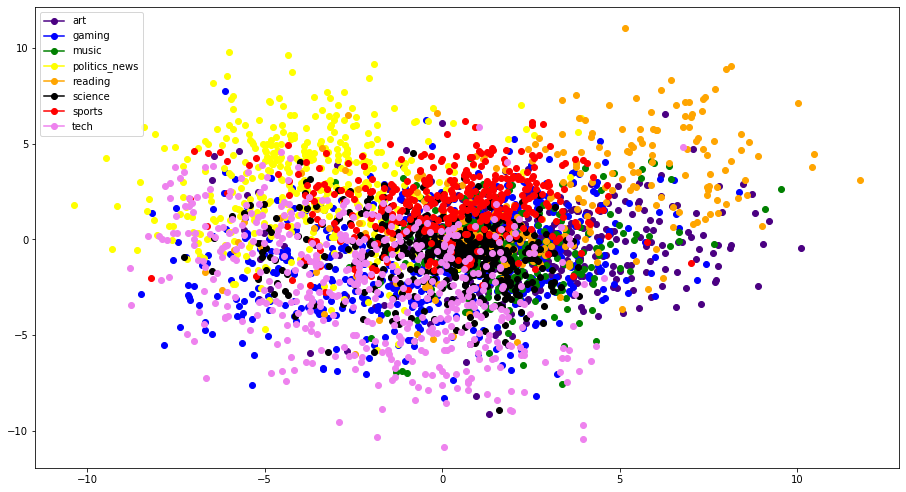

In [279]:
colors = {'sports': ['red', 0], 'reading': ['orange', 0], 'politics_news': ['yellow', 0], 'music': ['green', 0], 'gaming': ['blue', 0], 'art': ['indigo', 0], 'tech': ['violet', 0], 'science': ['black', 0]}

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for i, sub in enumerate(X_plot):
    ax.plot(sub[0], sub[1], color=colors[documents[i][1]][0], marker='o', label=get_label(i, colors, documents))
    
ax.legend()

**K-Means with doc2vec**

In [280]:
km = MiniBatchKMeans(n_clusters=38, init='k-means++', n_init=3)
km.fit(doc_vectors)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=38, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Text(0.5, 1.0, 'K-Means Clustering')

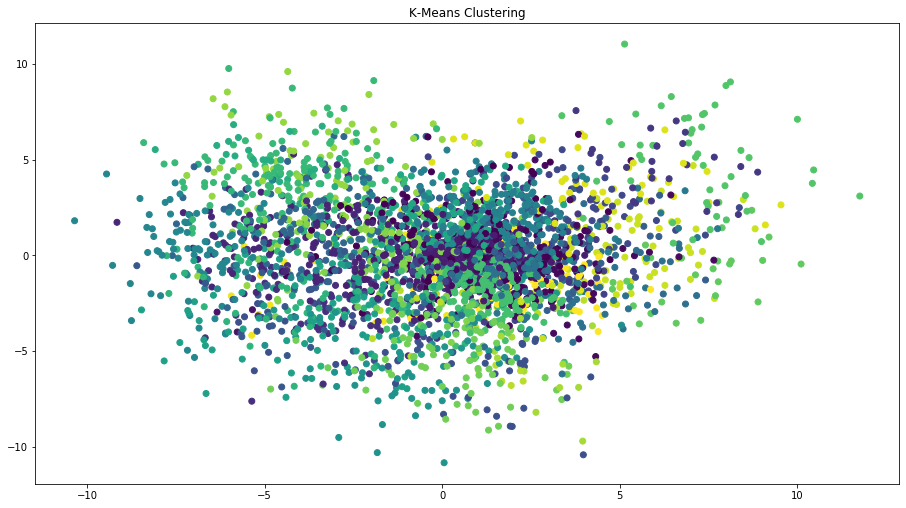

In [281]:
fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

In [282]:
print(f'Silhouette score: {metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1))}')

Silhouette score: 0.004785070661455393


In [283]:
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Homogeneity: 0.466
Completeness: 0.294
V-measure: 0.361


In [171]:
sill = []
list_k = list(range(2, 100))
for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++')
    km.fit(doc_vectors)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))

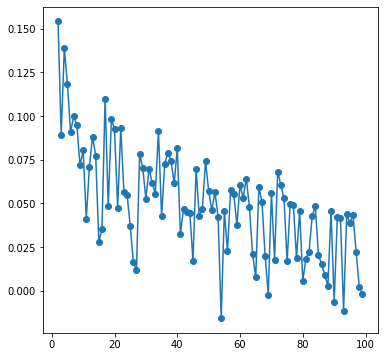

In [172]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o')

In [173]:
v = []
list_k = list(range(2, 100))
for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++')
    km.fit(doc_vectors)
    v.append(metrics.v_measure_score(labels, km.labels_))

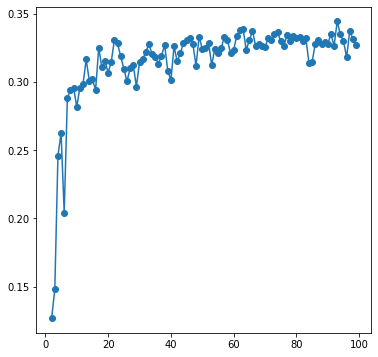

In [174]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, v, marker='o')

In [291]:
doc_id = random.randint(0, len(tagged_data) - 1)
inferred_vector = model.infer_vector(tagged_data[doc_id][0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

In [310]:
indexes = np.array(sims[1:11], dtype=int)[:, 0]

In [311]:
for index in indexes:
    print(documents[index][1])

politics_news
politics_news
politics_news
tech
politics_news
art
politics_news
tech
tech
politics_news


In [313]:
for index in indexes:
    print(documents[index][3])

PoliticalHumor
PoliticalHumor
PoliticalHumor
tech
PoliticalHumor
art
PoliticalHumor
tech
technology
PoliticalHumor
